In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import (setup_petri_model, reset_model, intervene_petri_model,
                                             sample_petri, calibrate_petri, optimize, load_petri_model)
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')


## Plotting utils

In [82]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population')
    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data.squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

COLORS=['red','blue','green','black','gold', 'magenta', 'purple']

def plot_trajectories(sol, tspan, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate(sol): # skip beta, gamma parameters
        
        if len(sol[var]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan, I_low, I_up,
                            alpha=0.2, color=COLORS[i], label=var)
        
        if var in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()
    return ax
    
def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='--', label=f'intervention at T={t}')

    return ax


# Deterministic Lotka Volterra

## Load model

In [43]:
from pyciemss.PetriNetODE.models import LotkaVolterra

raw_deterministic_lotka_volterra = LotkaVolterra(alpha=.67, beta=1.33, gamma=1.00, delta=1.00, add_uncertainty=False)
raw_deterministic_lotka_volterra

LotkaVolterra()

## Initialize model

In [44]:
deterministic_lotka_volterra = setup_petri_model(raw_deterministic_lotka_volterra, start_time=0.0, start_state=dict(prey_population=1.0, predator_population=1.0))
deterministic_lotka_volterra

LotkaVolterra()

In [45]:
tspan = get_tspan(1, 50, 500)

## Sample trajectory

In [46]:
deterministic_lotka_volterra_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
deterministic_lotka_volterra_trajectory['prey_population_sol'][0][0]

tensor(0.5775)

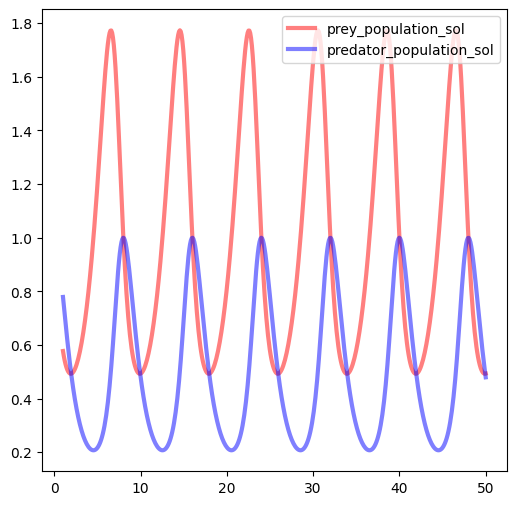

In [47]:
ax = plot_trajectories(deterministic_lotka_volterra_trajectory, tspan)



# Load lotka volterra  with uncertainty

In [35]:
from pyciemss.PetriNetODE.models import LotkaVolterra

uncertain_lotka_volterra_raw= LotkaVolterra(alpha=0.67, beta=1.33, gamma=1.0, delta=1.0, pseudocount=10)
uncertain_lotka_volterra_raw

LotkaVolterra()

## Initialize uncertain Lotka-volterra model

In [36]:
uncertain_lotka_volterra = setup_petri_model(uncertain_lotka_volterra_raw,
                                             start_time=0.0, 
                                             start_state=dict(
                                                 prey_population=1.00, 
                                                 predator_population=1.00))
uncertain_lotka_volterra

LotkaVolterra()

## Sample from prior

In [37]:

prior_samples = sample_petri(uncertain_lotka_volterra, tspan, 50)
prior_samples.keys()

dict_keys(['alpha', 'beta', 'gamma', 'delta', 'prey_population_sol', 'predator_population_sol'])

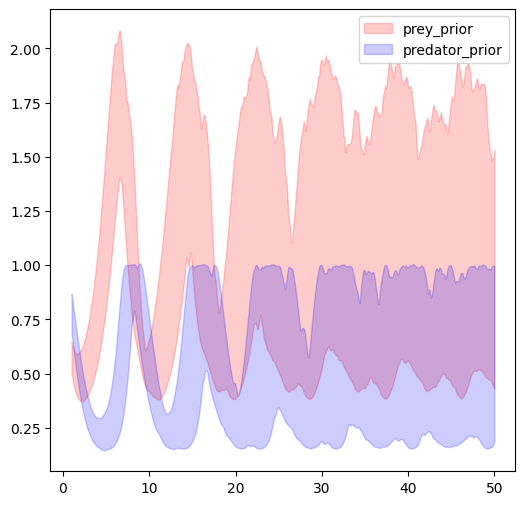

In [38]:
plot_trajectories({'prey_prior': prior_samples['prey_population_sol'], 'predator_prior': prior_samples['predator_population_sol']},tspan)

## Calibrate uncertain Lotka Volterra

We make one observation per day. Because we simulate 500 data points over 50 days, we need to sample every 10th timepoint.

In [54]:
fitted_parameters = calibrate_petri(uncertain_lotka_volterra, 
                                data =[(i, dict(prey_population=deterministic_lotka_volterra_trajectory['prey_population_sol'][0][i*10]))
                                       for i in range(1,50)])
fitted_parameters

AutoLowRankMultivariateNormal()

In [55]:
posterior_samples = sample_petri(uncertain_lotka_volterra, 
                                 timepoints=tspan, num_samples=50, 
                           inferred_parameters=fitted_parameters)
posterior_samples.keys()

dict_keys(['alpha', 'beta', 'gamma', 'delta', 'prey_population_sol', 'predator_population_sol'])

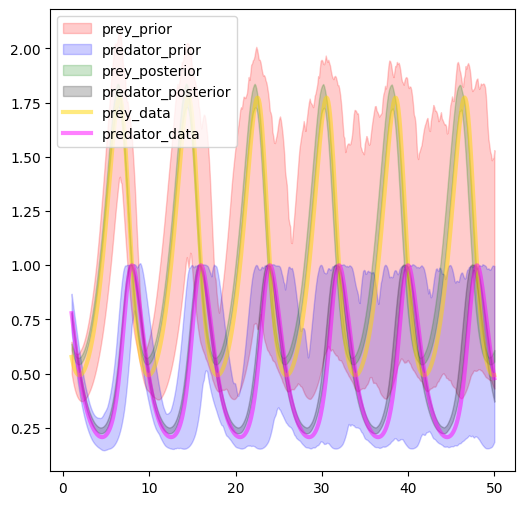

In [56]:
plot_trajectories({
    'prey_prior': prior_samples['prey_population_sol'], 
                  'predator_prior': prior_samples['predator_population_sol'],
                  'prey_posterior': posterior_samples['prey_population_sol'],
                 'predator_posterior': posterior_samples['predator_population_sol'],
                  'prey_data': deterministic_lotka_volterra_trajectory['prey_population_sol'],
                  'predator_data': deterministic_lotka_volterra_trajectory['predator_population_sol']
    },    tspan)

## Intervene on uncertain Lotka Volterra

In [66]:
intervened_lotka_volterra = intervene_petri_model(uncertain_lotka_volterra,
                                                  [(25, 'alpha', 1.0)])
intervened_lotka_volterra

LotkaVolterra()

## Sample from intervened model

At $t=25$ we intervene to set $\alpha=1.0$.

In [67]:
intervened_samples = sample_petri(intervened_lotka_volterra,
                                  timepoints=tspan, num_samples = 50
                                  )
intervened_samples

{'alpha': tensor([0.6624, 0.6843, 0.7047, 0.6539, 0.7074, 0.7099, 0.7182, 0.6403, 0.7134,
         0.6384, 0.6852, 0.6098, 0.6546, 0.6696, 0.7364, 0.6449, 0.6458, 0.7183,
         0.7324, 0.7115, 0.6857, 0.7162, 0.6688, 0.6502, 0.6067, 0.6752, 0.6590,
         0.7026, 0.6293, 0.6036, 0.6197, 0.6094, 0.6384, 0.6512, 0.6253, 0.6744,
         0.6063, 0.7318, 0.7182, 0.6795, 0.6132, 0.7192, 0.6239, 0.7097, 0.7033,
         0.6635, 0.6561, 0.6711, 0.6146, 0.6250]),
 'beta': tensor([1.2018, 1.3156, 1.4592, 1.2542, 1.3595, 1.3585, 1.3360, 1.4043, 1.3866,
         1.3798, 1.4486, 1.2146, 1.4514, 1.3950, 1.3011, 1.3959, 1.2495, 1.3205,
         1.2956, 1.2120, 1.4376, 1.2955, 1.2201, 1.3616, 1.3305, 1.2625, 1.3408,
         1.3378, 1.2045, 1.2879, 1.2045, 1.4546, 1.3393, 1.2431, 1.3186, 1.2337,
         1.2828, 1.4141, 1.2356, 1.3565, 1.4052, 1.3349, 1.2371, 1.4025, 1.3785,
         1.3187, 1.3781, 1.4206, 1.2261, 1.2303]),
 'gamma': tensor([0.9953, 0.9165, 0.9715, 1.0141, 0.9876, 1.0047, 0.975

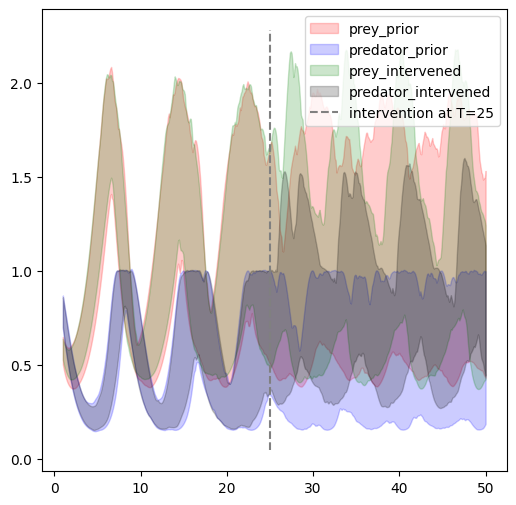

In [83]:

ax = plot_trajectories({
    'prey_prior': prior_samples['prey_population_sol'], 
                  'predator_prior': prior_samples['predator_population_sol'],
                  'prey_intervened': intervened_samples['prey_population_sol'],
                 'predator_intervened': intervened_samples['predator_population_sol'],
                 # 'prey_data': deterministic_lotka_volterra_trajectory['prey_population_sol'],
                 # 'predator_data': deterministic_lotka_volterra_trajectory['predator_population_sol']
    },    tspan)
ax = plot_intervention_line(25, ax=ax)
ax.legend()

## Sample from counterfactual distribution

Given that we observe the deterministic trajectory in the factual world,
what would be the trajectory in a counterfactual world where we intervene at $t=25$ to set $\alpha=1.5$?

In [70]:
counterfactual_samples = sample_petri(intervened_lotka_volterra,
                                  timepoints=tspan, num_samples = 50,
                                      inferred_parameters=fitted_parameters
                                  )
counterfactual_samples

{'alpha': tensor([0.6621, 0.6667, 0.6625, 0.6708, 0.6567, 0.6691, 0.6667, 0.6665, 0.6665,
         0.6644, 0.6618, 0.6636, 0.6679, 0.6614, 0.6748, 0.6618, 0.6670, 0.6673,
         0.6673, 0.6640, 0.6730, 0.6695, 0.6759, 0.6662, 0.6616, 0.6599, 0.6650,
         0.6719, 0.6697, 0.6759, 0.6708, 0.6694, 0.6690, 0.6676, 0.6743, 0.6625,
         0.6660, 0.6579, 0.6671, 0.6667, 0.6705, 0.6688, 0.6681, 0.6599, 0.6568,
         0.6594, 0.6707, 0.6571, 0.6645, 0.6657]),
 'beta': tensor([1.2281, 1.2376, 1.2277, 1.2798, 1.2620, 1.2733, 1.2529, 1.2831, 1.2567,
         1.3006, 1.2802, 1.2963, 1.2575, 1.2314, 1.2800, 1.2633, 1.2622, 1.2592,
         1.2529, 1.2677, 1.2901, 1.2624, 1.2561, 1.2259, 1.2191, 1.2238, 1.2311,
         1.2420, 1.2371, 1.2800, 1.2522, 1.2555, 1.2385, 1.2674, 1.2478, 1.2415,
         1.2308, 1.2228, 1.2675, 1.2563, 1.2940, 1.2726, 1.2501, 1.2351, 1.2270,
         1.2282, 1.2446, 1.2598, 1.2339, 1.2340]),
 'gamma': tensor([1.0121, 1.0038, 1.0068, 1.0057, 1.0320, 1.0086, 1.001

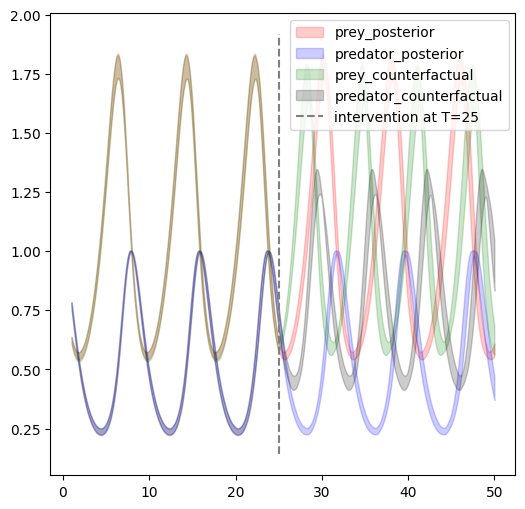

In [84]:
ax= plot_trajectories({
    'prey_posterior': posterior_samples['prey_population_sol'], 
                  'predator_posterior': posterior_samples['predator_population_sol'],
                  'prey_counterfactual': counterfactual_samples['prey_population_sol'],
                 'predator_counterfactual': counterfactual_samples['predator_population_sol'],
                 # 'prey_data': deterministic_lotka_volterra_trajectory['prey_population_sol'],
                 # 'predator_data': deterministic_lotka_volterra_trajectory['predator_population_sol']
    },    tspan)
ax = plot_intervention_line(25, ax)
ax.legend()